In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/Datasets/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Datasets')

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_dir = '/content/drive/MyDrive/Datasets/Food Classification'
train_dir = '/content/drive/MyDrive/Datasets/Food_Train'
test_dir = '/content/drive/MyDrive/Datasets/Food_Test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for item in os.listdir(source_dir):
    item_path = os.path.join(source_dir, item)
    if os.path.isdir(item_path):
        images = os.listdir(item_path)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, item), exist_ok=True)
        os.makedirs(os.path.join(test_dir, item), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(item_path, img), os.path.join(train_dir, item, img))
        for img in test_images:
            shutil.copy(os.path.join(item_path, img), os.path.join(test_dir, item, img))

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

source_dir = '/content/drive/MyDrive/Datasets/Food Classification'
train_dir = '/content/drive/MyDrive/Datasets/Food_Classification/Food_Train'
test_dir = '/content/drive/MyDrive/Datasets/Food_Classification/Food_Test'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Copy the extracted dataset to Colab's local disk for faster access
!cp -r /content/drive/MyDrive/Datasets/Food_Classification /content/Food_Classification

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = '/content/Food_Classification/Food_Train'
test_dir = '/content/Food_Classification/Food_Test'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def test(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(loader)
    test_acc = correct / total
    return test_loss, test_acc

In [ ]:
import torch
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
set_seed(42)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class FoodCNN(nn.Module):
    def __init__(self, num_classes=20):
        super(FoodCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FoodCNN(num_classes=20).to(device)

In [ ]:
set_seed(42)

num_epochs = 30
learning_rate = 0.00005

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    scheduler.step(test_loss)
    print(f"Learning rate after epoch {epoch+1}: {scheduler.optimizer.param_groups[0]['lr']}")

Epoch [1/30], Train Loss: 2.9498, Train Acc: 0.0959, Test Loss: 2.7839, Test Acc: 0.1719
Learning rate after epoch 1: 5e-05
Epoch [2/30], Train Loss: 2.7635, Train Acc: 0.1522, Test Loss: 2.5570, Test Acc: 0.2464
Learning rate after epoch 2: 5e-05
Epoch [3/30], Train Loss: 2.6011, Train Acc: 0.1977, Test Loss: 2.4066, Test Acc: 0.3074
Learning rate after epoch 3: 5e-05
Epoch [4/30], Train Loss: 2.5022, Train Acc: 0.2295, Test Loss: 2.3321, Test Acc: 0.2908
Learning rate after epoch 4: 5e-05
Epoch [5/30], Train Loss: 2.4117, Train Acc: 0.2594, Test Loss: 2.1717, Test Acc: 0.3455
Learning rate after epoch 5: 5e-05
Epoch [6/30], Train Loss: 2.3196, Train Acc: 0.2908, Test Loss: 2.1266, Test Acc: 0.3574
Learning rate after epoch 6: 5e-05
Epoch [7/30], Train Loss: 2.2122, Train Acc: 0.3184, Test Loss: 2.0502, Test Acc: 0.3756
Learning rate after epoch 7: 5e-05
Epoch [8/30], Train Loss: 2.1206, Train Acc: 0.3473, Test Loss: 1.9704, Test Acc: 0.4033
Learning rate after epoch 8: 5e-05
Epoch [9

KeyboardInterrupt: 

In [ ]:
model_path = '/content/drive/MyDrive/Datasets/food_cnn_model_0.00005_29_epochs.pth'
torch.save(model.state_dict(), model_path)
print("Model saved to Google Drive.")

Model saved to Google Drive.


In [ ]:
set_seed(42)

model_path = '/content/drive/MyDrive/Datasets/food_cnn_model_0.00005_29_epochs.pth'
model = FoodCNN(num_classes=20)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

<ipython-input-13-492e491a6cbd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


FoodCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

       burger       0.93      0.63      0.75        62
  butter_naan       0.38      0.64      0.48        66
         chai       0.62      0.69      0.65        77
      chapati       0.32      0.67      0.44        83
chole_bhature       0.50      0.41      0.45        83
  dal_makhani       0.64      0.69      0.67        65
       dhokla       0.68      0.66      0.67        58
   fried_rice       0.81      0.65      0.72        71
         idli       0.67      0.63      0.65        62
       jalebi       0.52      0.72      0.61        60
 kaathi_rolls       0.46      0.32      0.38        59
 kadai_paneer       0.78      0.52      0.62        83
        kulfi       0.38      0.28      0.32        47
  masala_dosa       0.40      0.37      0.38        63
        momos       0.46      0.72      0.56        64
   paani_puri       0.00      0.00      0.00        26
       pakode       0.62      0.32      0

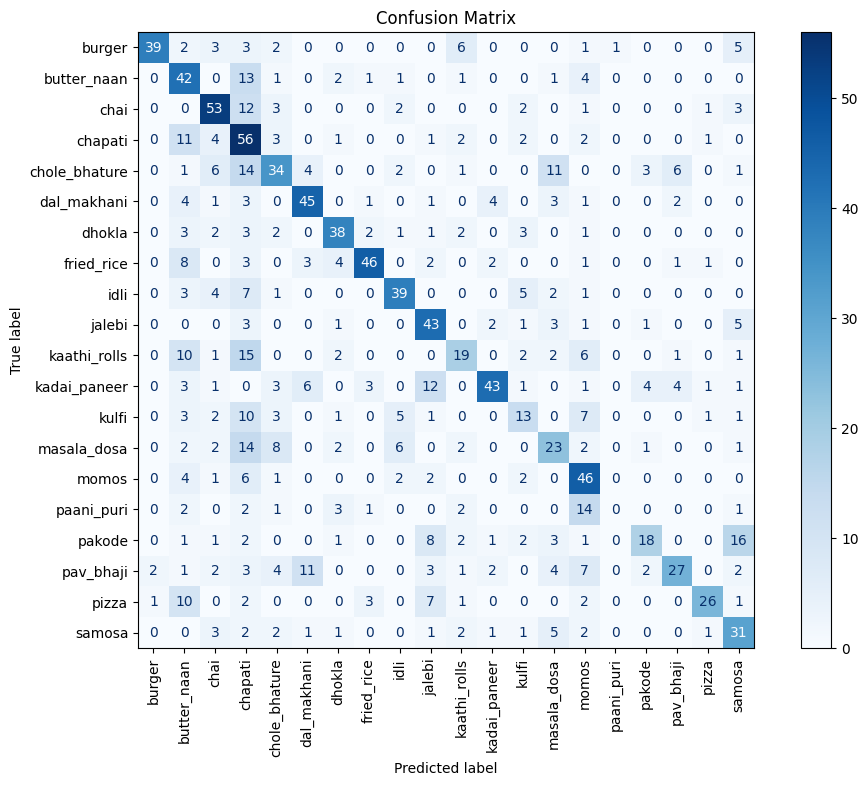

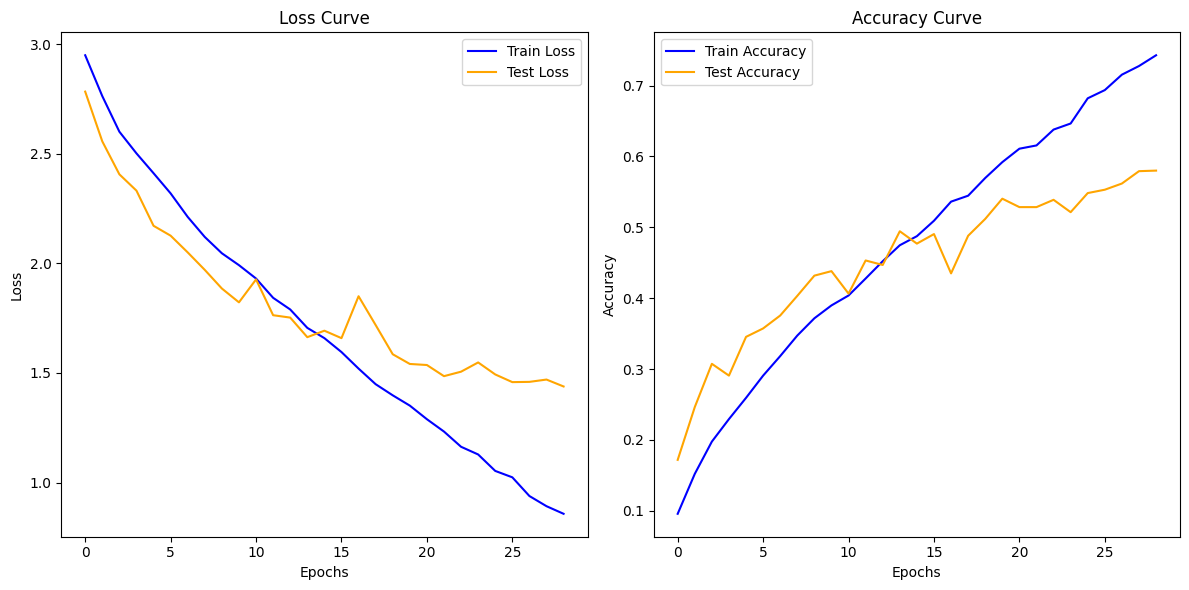

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

preds, labels = evaluate_model(model, test_loader, device)

print("Classification Report:")
print(classification_report(labels, preds, target_names=train_data.classes))

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)

plt.figure(figsize=(12, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
               precision    recall  f1-score     support
burger          0.928571  0.629032  0.750000    62.00000
butter_naan     0.381818  0.636364  0.477273    66.00000
chai            0.616279  0.688312  0.650307    77.00000
chapati         0.323699  0.674699  0.437500    83.00000
chole_bhature   0.500000  0.409639  0.450331    83.00000
dal_makhani     0.642857  0.692308  0.666667    65.00000
dhokla          0.678571  0.655172  0.666667    58.00000
fried_rice      0.807018  0.647887  0.718750    71.00000
idli            0.672414  0.629032  0.650000    62.00000
jalebi          0.524390  0.716667  0.605634    60.00000
kaathi_rolls    0.463415  0.322034  0.380000    59.00000
kadai_paneer    0.781818  0.518072  0.623188    83.00000
kulfi           0.382353  0.276596  0.320988    47.00000
masala_dosa     0.403509  0.365079  0.383333    63.00000
momos           0.455446  0.718750  0.557576    64.00000
paani_puri      0.000000  0.000000  0.000000    26.00000
pakode  

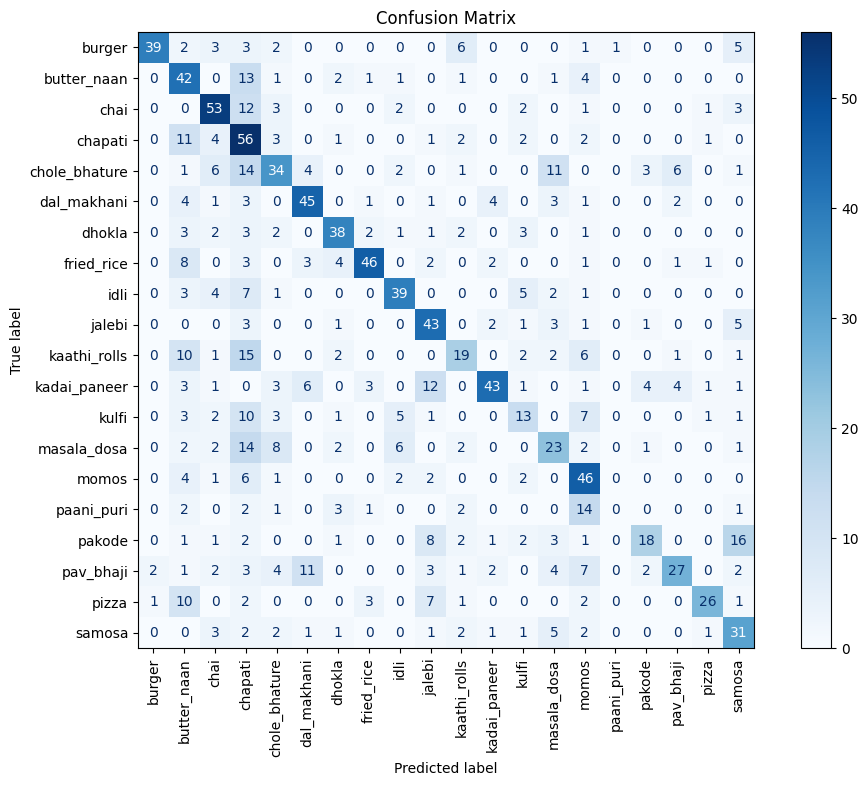

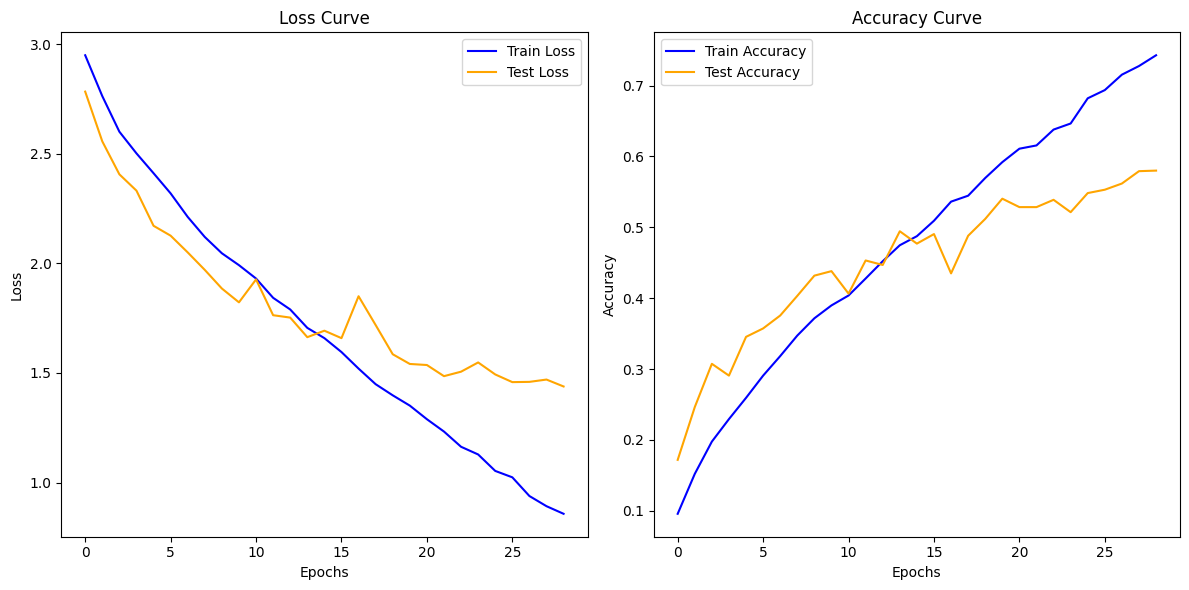

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

preds, labels = evaluate_model(model, test_loader, device)

report_dict = classification_report(labels, preds, target_names=train_data.classes, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()

# Print the classification report DataFrame
print("Classification Report:")
print(report_df)

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)

plt.figure(figsize=(12, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
excel_filename = 'classification_report.xlsx'
report_df.to_excel(excel_filename, index=True)

In [ ]:
import os

dataset_dir = '/content/drive/MyDrive/Datasets/Food Classification'
class_names = sorted(os.listdir(dataset_dir))

In [ ]:
class_labels = {i: name for i, name in enumerate(class_names)}

class_labels

{0: '0901MC2210003 ADWITIYA KHARE.pdf',
 1: 'burger',
 2: 'butter_naan',
 3: 'chai',
 4: 'chapati',
 5: 'chole_bhature',
 6: 'dal_makhani',
 7: 'dhokla',
 8: 'fried_rice',
 9: 'idli',
 10: 'jalebi',
 11: 'kaathi_rolls',
 12: 'kadai_paneer',
 13: 'kulfi',
 14: 'masala_dosa',
 15: 'momos',
 16: 'paani_puri',
 17: 'pakode',
 18: 'pav_bhaji',
 19: 'pizza',
 20: 'samosa'}